# 05 — Explainability with SHAP (Credit Card Fraud Detection)

## Objective

The goal of this notebook is to explain the predictions of the best-performing
machine learning model using **SHAP (SHapley Additive exPlanations)**.

This notebook aims to:
- Understand **global feature importance** for fraud detection
- Explain **individual predictions** (why a transaction is flagged as fraud)
- Improve transparency and interpretability of the model
- Discuss limitations of SHAP in the context of highly imbalanced tabular data

SHAP is applied to a **tree-based model**, as these models achieved the best
performance in previous experiments.


In [4]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Model loading
import joblib

# SHAP
import shap


## Load Preprocessed Data

In this notebook, we reuse the preprocessed datasets generated in the
previous steps of the project.

All feature engineering, scaling, and transformations have already been applied.
The data is stored as NumPy arrays to ensure consistency with the trained models.


In [5]:
# Load transformed feature matrices
X_train = np.load("../data/processed/X_train_transformed.npy")
X_val   = np.load("../data/processed/X_val_transformed.npy")
X_test  = np.load("../data/processed/X_test_transformed.npy")

# Load labels
y_train = np.load("../data/processed/y_train.npy").ravel()
y_val   = np.load("../data/processed/y_val.npy").ravel()
y_test  = np.load("../data/processed/y_test.npy").ravel()

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

print("\nFraud ratio (test):", round(y_test.mean() * 100, 4), "%")


Shapes:
X_train: (170883, 30) y_train: (170883,)
X_val:   (28481, 30) y_val:   (28481,)
X_test:  (85443, 30) y_test:  (85443,)

Fraud ratio (test): 0.1732 %


## Load the Trained Model

To perform explainability analysis with SHAP, we load the **best-performing
tree-based model** trained in previous notebooks.

Tree-based models are well supported by SHAP through `TreeExplainer`,
which provides efficient and reliable explanations.

In this notebook, we explain the predictions of the selected model.


In [6]:
# List all saved model files
model_files = [f for f in os.listdir("../results") if f.endswith(".pkl")]
model_files


['decision_tree_model.pkl',
 'knn_(k=5)_model.pkl',
 'knn_k=5_model.pkl',
 'logistic_regression_model.pkl',
 'random_forest_model.pkl',
 'random_forest_tuned_model.pkl',
 'svm_rbf_model.pkl']

In [7]:
# Load the tuned Random Forest model
MODEL_PATH = "../results/random_forest_tuned_model.pkl"

model = joblib.load(MODEL_PATH)

print("Loaded model type:", type(model))
print("Model path:", MODEL_PATH)


Loaded model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Model path: ../results/random_forest_tuned_model.pkl


## Feature Names for Explainability

The model was trained on **transformed features**, and explicit original feature
names are not available at this stage.

Therefore, we assign generic feature names:
- `f0, f1, ..., f29`

These names are used consistently in SHAP visualizations.
While this limits direct semantic interpretation, it still allows us to:
- Compare relative feature importance
- Analyze how feature values influence fraud predictions


In [8]:
# Create generic feature names
n_features = X_train.shape[1]
feature_names = [f"f{i}" for i in range(n_features)]

print("Number of features:", n_features)
print("First 5 feature names:", feature_names[:5])


Number of features: 30
First 5 feature names: ['f0', 'f1', 'f2', 'f3', 'f4']


## SHAP Sampling Strategy

Computing SHAP values on the full dataset can be computationally expensive.
To ensure reproducibility and reasonable execution time, we use a sampling strategy:

- A **background sample** from the training set is used by `TreeExplainer`
- A **subset of the test set** is used for explanation

This approach provides representative explanations while keeping
the computation tractable.


In [9]:
# Reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Background sample for TreeExplainer
bg_size = min(5000, X_train.shape[0])
bg_indices = rng.choice(X_train.shape[0], size=bg_size, replace=False)
X_background = X_train[bg_indices]

# Subset of test data for SHAP explanations
explain_size = min(10000, X_test.shape[0])
explain_indices = rng.choice(X_test.shape[0], size=explain_size, replace=False)
X_explain = X_test[explain_indices]
y_explain = y_test[explain_indices]

print("Background sample shape:", X_background.shape)
print("Explain sample shape   :", X_explain.shape)
print("Fraud ratio in explain sample:", round(y_explain.mean() * 100, 4), "%")


Background sample shape: (5000, 30)
Explain sample shape   : (10000, 30)
Fraud ratio in explain sample: 0.2 %


## SHAP TreeExplainer

For tree-based models such as Random Forests, SHAP provides `TreeExplainer`,
which is optimized for efficiency and accuracy.

We compute SHAP values for the **fraud class (class = 1)** to understand
which features contribute to increasing or decreasing the probability
of a transaction being classified as fraudulent.


In [11]:
# Create TreeExplainer using the background sample
explainer = shap.TreeExplainer(model, data=X_background)

# Compute SHAP values for the explanation subset
# Note: For binary classification, SHAP may return:
# - a list: [class_0, class_1]
# - OR a single array (n_samples, n_features)
shap_values = explainer.shap_values(X_explain, check_additivity=False)

# Extract SHAP values for the fraud class (class = 1)
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_fraud = shap_values[1]
else:
    shap_fraud = shap_values

print("SHAP values shape (fraud class):", shap_fraud.shape)


 99%|===================| 19818/20000 [01:40<00:00]        

SHAP values shape (fraud class): (10000, 30, 2)


In [12]:
# Handle SHAP output shape for binary classification
# Expected shapes:
# (n_samples, n_features) OR (n_samples, n_features, n_classes)

if shap_fraud.ndim == 3:
    # Select SHAP values for fraud class (class index = 1)
    shap_fraud = shap_fraud[:, :, 1]

print("Final SHAP fraud matrix shape:", shap_fraud.shape)


Final SHAP fraud matrix shape: (10000, 30)


## Global Explainability — Feature Importance

To understand the overall behavior of the model, we analyze **global feature importance**
using SHAP values.

We use two complementary visualizations:
- **Bar summary plot**: shows the mean absolute SHAP value for each feature
- **Beeswarm plot**: shows the distribution of SHAP values across samples

These plots answer the question:
> Which features contribute the most to fraud predictions overall?


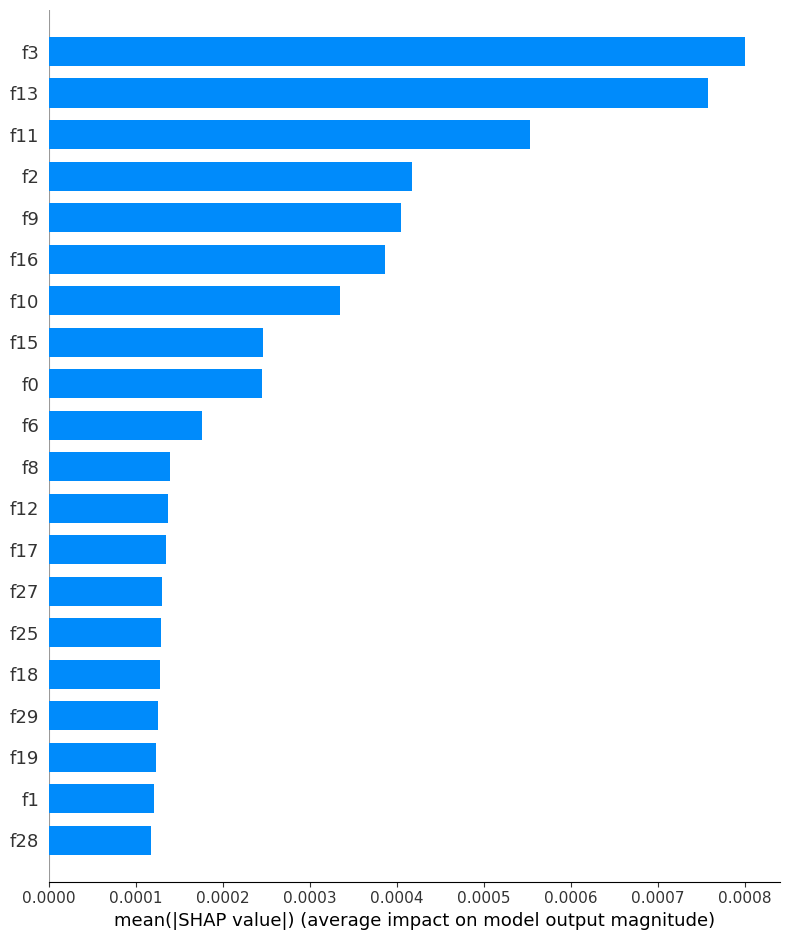

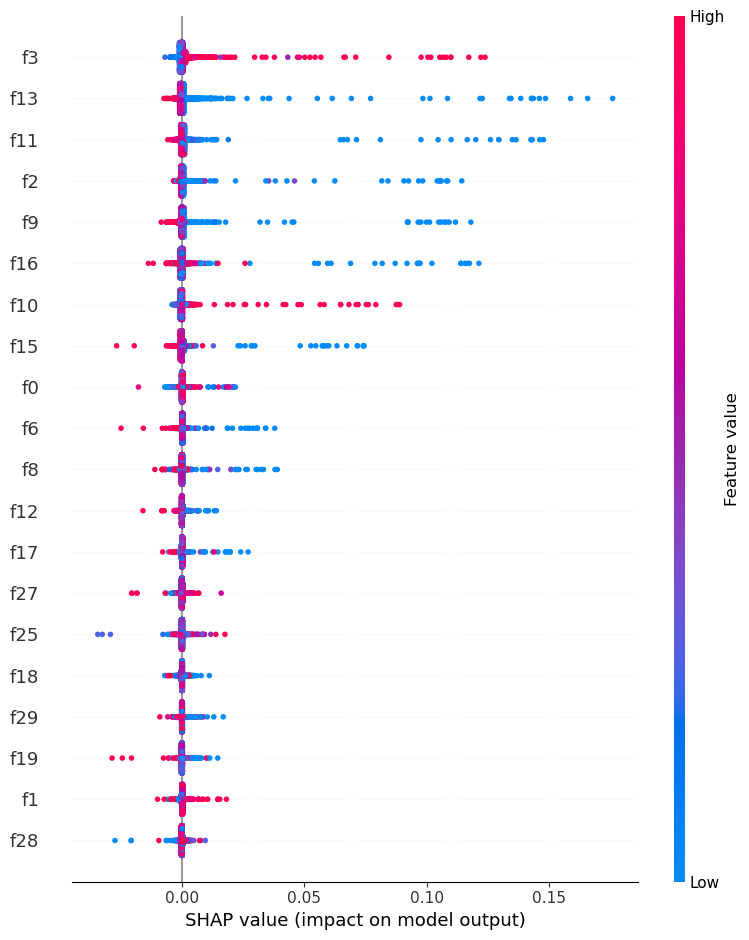

In [13]:
# Create output directory for figures
os.makedirs("../results/figures", exist_ok=True)

# Global feature importance (bar plot)
shap.summary_plot(
    shap_fraud,
    X_explain,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

# Global feature importance (beeswarm plot)
shap.summary_plot(
    shap_fraud,
    X_explain,
    feature_names=feature_names,
    show=True
)


## Local Explainability — Individual Predictions

Global feature importance explains overall model behavior, but fraud detection
often requires understanding **why a specific transaction is flagged**.

In this section, we analyze **local explanations** using SHAP for:
- One **fraudulent transaction**
- One **non-fraudulent transaction**

This helps illustrate how individual feature contributions push the model
toward or away from predicting fraud.


In [14]:
# Identify indices of fraud and non-fraud samples in the explanation subset
fraud_indices = np.where(y_explain == 1)[0]
nonfraud_indices = np.where(y_explain == 0)[0]

print("Number of fraud samples in explanation set:", len(fraud_indices))
print("Number of non-fraud samples in explanation set:", len(nonfraud_indices))

# Select one example of each (safe selection)
idx_fraud = int(fraud_indices[0]) if len(fraud_indices) > 0 else 0
idx_nonfraud = int(nonfraud_indices[0]) if len(nonfraud_indices) > 0 else 0

print("Selected fraud index:", idx_fraud, "label:", y_explain[idx_fraud])
print("Selected non-fraud index:", idx_nonfraud, "label:", y_explain[idx_nonfraud])


Number of fraud samples in explanation set: 20
Number of non-fraud samples in explanation set: 9980
Selected fraud index: 406 label: 1
Selected non-fraud index: 0 label: 0


## Local Explainability — SHAP Waterfall Plots

To explain individual predictions, we use **SHAP waterfall plots**.

A waterfall plot shows:
- The **base value** (average model output)
- How each feature pushes the prediction **toward fraud or non-fraud**
- The final predicted output for the selected transaction

We visualize:
- One **fraudulent transaction**
- One **non-fraudulent transaction**


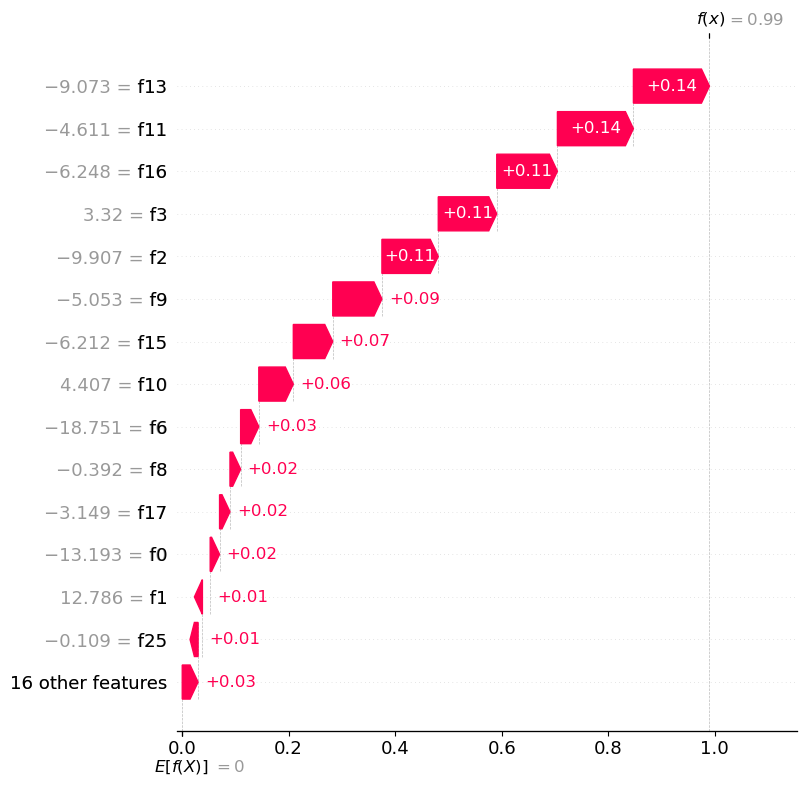

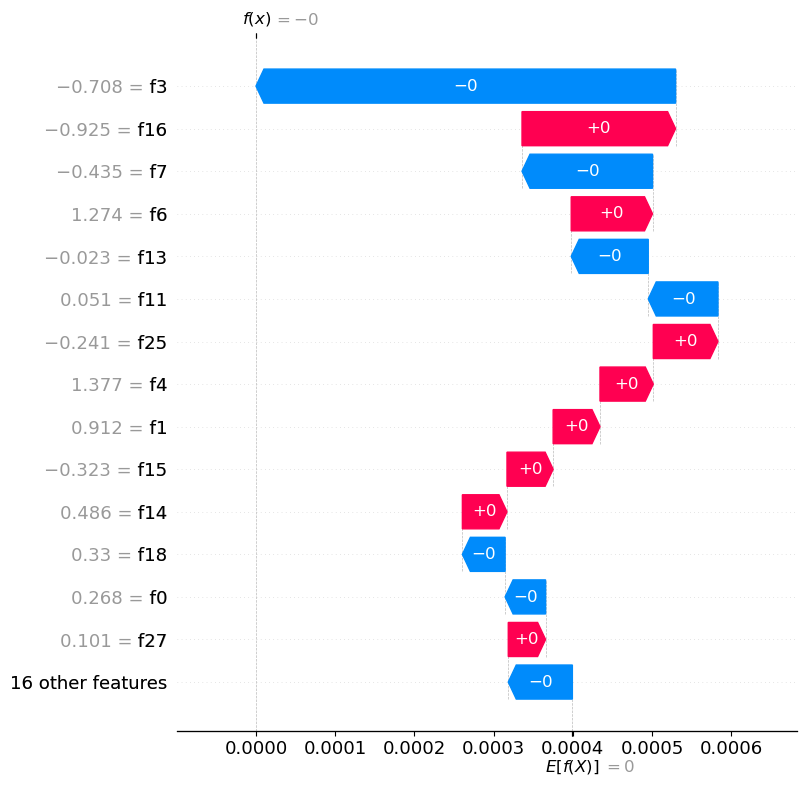

In [15]:
# Determine base value for the fraud class
if isinstance(explainer.expected_value, (list, np.ndarray)):
    base_value = explainer.expected_value[1]
else:
    base_value = explainer.expected_value

# --- Fraud example ---
exp_fraud = shap.Explanation(
    values=shap_fraud[idx_fraud],
    base_values=base_value,
    data=X_explain[idx_fraud],
    feature_names=feature_names
)

shap.plots.waterfall(exp_fraud, max_display=15, show=True)

# --- Non-fraud example ---
exp_nonfraud = shap.Explanation(
    values=shap_fraud[idx_nonfraud],
    base_values=base_value,
    data=X_explain[idx_nonfraud],
    feature_names=feature_names
)

shap.plots.waterfall(exp_nonfraud, max_display=15, show=True)


## Critical Discussion and Limitations

### Global Insights
The SHAP global summary plots highlight the most influential transformed features
contributing to fraud predictions. A small subset of features dominates the model’s
decision-making process, which is expected for this dataset.

The beeswarm plot further shows that extreme feature values tend to have a strong
impact on pushing predictions toward the fraud class.

---

### Local Insights
Local SHAP waterfall plots provide a clear explanation of individual predictions:
- Fraudulent transactions are characterized by a few strong positive SHAP contributions
- Non-fraudulent transactions show balanced or negative contributions that keep the
  predicted probability below the decision threshold

These explanations help justify why the model flags certain transactions and improve
trust in the prediction process.

---

### Limitations
Several limitations should be considered when interpreting SHAP results:

- **Sampling**: SHAP values were computed on a subset of the data for computational
  efficiency. Feature importance rankings may vary slightly with different samples.
- **Transformed features**: Because the data is preprocessed, feature names are generic
  (`f0`–`f29`), limiting direct semantic interpretation.
- **Feature correlation**: SHAP assumes feature independence; correlated features can
  affect attribution accuracy.
- **Model-specific explanations**: SHAP explanations are tied to the selected model.
  Different models may yield different explanations.

---

### Conclusion
SHAP provides valuable insights into both global model behavior and individual fraud
predictions. While explanations should be interpreted with caution, especially for
transformed and correlated features, SHAP significantly improves transparency and
interpretability in fraud detection systems.
